In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.semi_supervised import LabelSpreading, LabelPropagation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
from scipy.stats import ks_2samp
import shap

# Replace infinite values with NaN

/home/ubuntu/anaconda3/envs/foundmdl/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# df = pd.read_csv("/home/ubuntu/AKI/analysis_aki.csv")
df = pd.read_csv("/home/ubuntu/AKI/analysis_without_urine_aki.csv")

X = df.drop('AKI_7DAY', axis=1)
y = df['AKI_7DAY']

X.replace([np.inf, -np.inf], np.nan, inplace=True)
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [3]:
np.unique(y)

array([0, 1])

In [4]:
# Identify categorical columns (non-numeric columns)
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

# Identify numeric columns
numeric_cols = X.select_dtypes(include=['number']).columns

# Create a transformer for numeric data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))  # Imputing missing values with the mean
])

# Create a transformer for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Impute missing values with 'missing'
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Apply one-hot encoding
])

# Combine transformers into a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])



In [5]:
# Process data using preprocessor
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Flatten the datasets for the KS test
X_train_flat = X_train_processed.flatten()
X_test_flat = X_test_processed.flatten()

# Perform Kolmogorov-Smirnov test
ks_statistic, p_value = ks_2samp(X_train_flat, X_test_flat)
print("KS Statistic:", ks_statistic)
print("P-value:", p_value)
# Decision based on p-value
if p_value > 0.05:
    print("Fail to reject the null hypothesis - suggests that the distributions of the training and testing samples are similar.")
else:
    print("Reject the null hypothesis - suggests that the distributions of the training and testing samples are different.")


KS Statistic: 0.000542687880779047
P-value: 0.8061442987981902
Fail to reject the null hypothesis - suggests that the distributions of the training and testing samples are similar.


In [6]:
# Define classifiers and hyperparameters
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=10000, n_jobs=-1, random_state=42),
    "Ridge Classifier": RidgeClassifier(),
    "LDA": LinearDiscriminantAnalysis(),
    "QDA": QuadraticDiscriminantAnalysis(),
    "SVC": SVC(probability=True, random_state=42),
    "KNeighbors": KNeighborsClassifier(n_jobs=-1),
    "Random Forest": RandomForestClassifier(random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Gaussian NB": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "MLP Classifier": MLPClassifier(max_iter=1000, random_state=42),
    "Label Spreading": LabelSpreading(kernel='knn', max_iter=1000, n_jobs=-1),
    "Label Propagation": LabelPropagation(kernel='knn', max_iter=1000, n_jobs=-1),
    "AdaBoost": AdaBoostClassifier(algorithm="SAMME", random_state=42)
}

# Grid of hyperparameters
param_grids = {
    "Logistic Regression": {"classifier__C": [0.01, 0.1, 1], "classifier__penalty": ["l1", "l2"]},
    "Ridge Classifier": {"classifier__alpha": [0.1, 1, 10, 100]},
    "LDA": {},
    "QDA": {"classifier__reg_param": [0.0, 0.1, 0.2, 0.3]},
    "SVC": {},
    "KNeighbors": {"classifier__n_neighbors": [3, 5, 7, 9], "classifier__metric": ["euclidean"]},
    "Random Forest": {"classifier__n_estimators": [50, 100, 200], "classifier__max_depth": [10, 20, 30]},
    "Gradient Boosting": {"classifier__n_estimators": [100, 200, 300], "classifier__learning_rate": [0.01, 0.1]},
    "Gaussian NB": {},
    "Decision Tree": {"classifier__max_depth": [5, 10, 20], "classifier__min_samples_split": [2, 5, 10]},
    "MLP Classifier": {"classifier__hidden_layer_sizes": [(50,), (100,), (50, 50)], "classifier__activation": ["relu"]},
    "Label Spreading": {"classifier__alpha": [0.01, 0.1, 0.2, 0.5]},
    "Label Propagation": {},
    "AdaBoost": {"classifier__n_estimators": [50, 100, 200], "classifier__learning_rate": [0.01, 0.1, 1]}
}


In [7]:
results = []

# Perform grid search
for name, classifier in classifiers.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])

    param_grid = param_grids.get(name, {})
    grid_search = GridSearchCV(pipeline, param_grid, cv=2, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)  # Direct use of DataFrame

    y_pred = grid_search.predict(X_test)

    # Metrics calculation
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')
    roc_auc = roc_auc_score(y_test, y_pred)
    pr_auc = average_precision_score(y_test, y_pred)

    results.append({
        "Classifier": name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "AUC-ROC": roc_auc,
        "AUC-PR": pr_auc
    })

# Create DataFrame from results
df_results = pd.DataFrame(results)
df_sorted = df_results.sort_values(by=["AUC-ROC", "AUC-PR"], ascending=[False, False])
df_sorted

/home/ubuntu/anaconda3/envs/foundmdl/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ubuntu/anaconda3/envs/foundmdl/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

,Classifier,Accuracy,Precision,Recall,F1 Score,AUC-ROC,AUC-PR
7,Gradient Boosting,0.823918,0.782570,0.734894,0.757983,0.806137,0.674577
10,MLP Classifier,0.810589,0.779674,0.690239,0.732236,0.786551,0.654387
6,Random Forest,0.803986,0.787642,0.653884,0.714558,0.774006,0.644893
13,AdaBoost,0.797010,0.754089,0.681109,0.715744,0.773861,0.633268
9,Decision Tree,0.785051,0.744257,0.650730,0.694358,0.758223,0.615360
0,Logistic Regression,0.781937,0.761126,0.610392,0.677476,0.747674,0.610770
2,LDA,0.776082,0.779003,0.562915,0.653561,0.733506,0.602511
1,Ridge Classifier,0.775459,0.781738,0.557105,0.650577,0.731847,0.601689
5,KNeighbors,0.741140,0.685612,0.572709,0.624096,0.707499,0.552980
12,Label Propagation,0.735098,0.674003,0.569389,0.617295,0.702001,0.545339


In [8]:
# Initialize and fit the model
model = GradientBoostingClassifier(random_state=42)

pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

param_grid = param_grids.get(name, {})
grid_search = GridSearchCV(pipeline, param_grid, cv=2, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)  # Direct use of DataFrame

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer())]),
                                                                         Index(['STAYTIME', 'AGE', 'LOS', 'COUNT TIMES GO ICU', 'EGFR', 'CREAT',
       'ANIONGAP_MIN', 'ANIONGAP_MAX', 'ALBUMIN_MIN', 'ALBUMIN_MAX',
       'BANDS_MIN', 'BANDS_MAX', 'BICARBONATE_MIN', 'BICARBONATE_MAX',
       'BILIRUBIN_MIN', 'BILIRUB...
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value='missing',
                                                                                                        strategy='constant')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         Index(['ETHNICITY', 'GENDER'], dtype='object'))])),
                                       ('classifier',
                                        GradientBoostingClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__learning_rate': [0.01, 0.1, 1],
                         'classifier__n_estimators': [50, 100, 200]},
             scoring='accuracy')

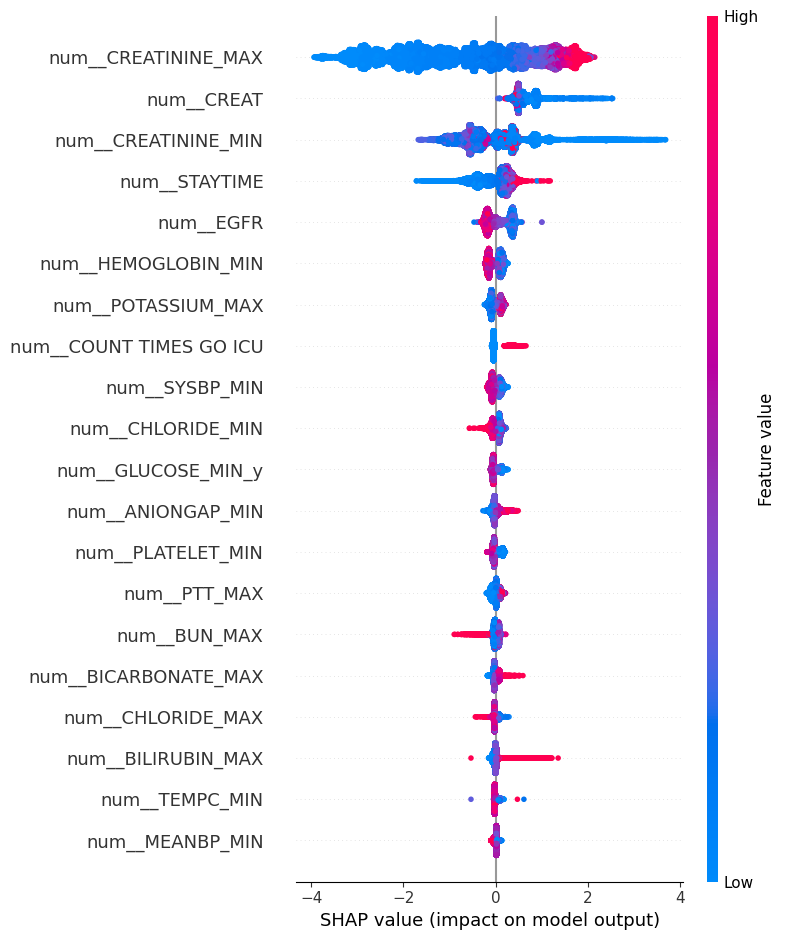

In [9]:


# Step 1: Extract the best estimator
best_model = grid_search.best_estimator_

# Step 2: Create a SHAP TreeExplainer
explainer = shap.TreeExplainer(best_model.named_steps['classifier'])

# Step 3: Calculate SHAP values
X_train_transformed = best_model.named_steps['preprocessor'].transform(X_train)
shap_values = explainer.shap_values(X_train_transformed)

# Obtain feature names
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

# Check if SHAP values are in a list (common with multi-class) or an array (common with binary)
if isinstance(shap_values, list):
    # This block is for multi-class but will be simplified here for binary classification
    # Assuming class 1 (positive class) is what we're interested in
    shap_values = shap_values[1]

# Calculate mean absolute SHAP values (this should be straightforward since we are dealing with a single array)
shap_values_avg = np.abs(shap_values).mean(axis=0)

# Step 4: Visualize summary plot
shap.summary_plot(shap_values, X_train_transformed, feature_names=feature_names)
# shap.plots.beeswarm(np.abs(shap_values), color="shap_red")

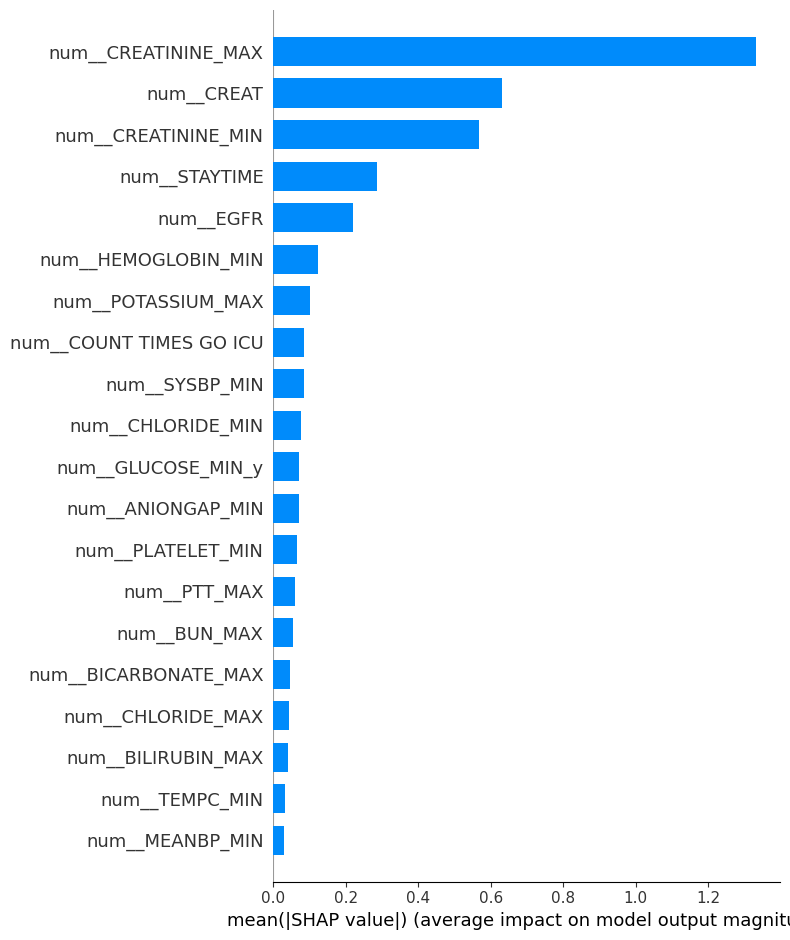

In [14]:

shap.summary_plot(shap_values, features= X_train_transformed,  feature_names=feature_names, plot_type='bar')
# f.savefig("summary_plot2.eps", bbox_inches='tight')
# f.savefig("summary_plot2.png", bbox_inches='tight')


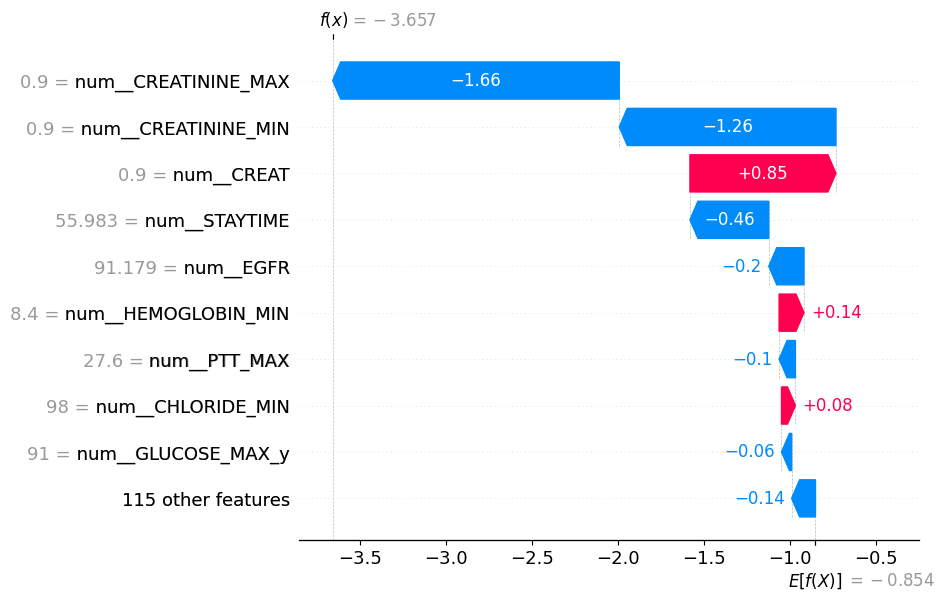

In [15]:
# Waterfall plot for the first prediction in the test set
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=feature_names)
# Select a specific observation to plot, e.g., the first one
observation_index = 0
shap.waterfall_plot(shap.Explanation(values=shap_values[observation_index], base_values=explainer.expected_value, data=X_train_transformed_df.iloc[observation_index], feature_names=feature_names))


In [4]:
X_train.shape

(37460, 83)